# MLP

## Code changes in notebook 08
Previous notebooks used the full list of GenCode sequences.
They would load the subset of labeled gene IDs (cell-line-specific) from LncATLAS.
Based on that subset, they would extract transcripts from all of GenCode.

This notebook uses a pared down set of sequence data.
The GenCode sequences were filtered to remove genes never referenced by LncATLAS.
These GenCode sequences were then split into train and test sets.
These sets were then processed to cound K-mers (only K=4 so far).

Code in this notebook, and in Splitter, were refactored code accordingly.
This code reads the LncAtlas gene IDs that have an RCI value for this cell line.
This code assigns a binary label based on global RCI thresholds.
The code makes an array of gene_id, transcript_id, label.
The code loads another array of K-mer counts for all possible K-mers.
The two arrays have a one-to-one correspondence of rows.

The genes are partitioned 5 times to make 5 non-overlapping validation sets.
On each iteration, the Splitter puts 1/5 of genes into the validation set,
and splits the kmercounts/labels into X/Y for both train and validation.

## Science results
This notebook uses coding sequence from the first cell line.
This notebook assigned labels 0 for RCI<0.083 and 1 for the rest.
That threshold had been reported as the mean RCI for training data in this cell line.
The model was a 3x64 MLP with sigmoid activation.

The 5-fold cross-validation accuracy had mean 66%, consistent with our previous results.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-16 09:28:30.674069
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10

from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Load labels and sequences

In [5]:
print(datetime.now())
splitter=Splitter()
print(datetime.now())

2022-10-16 09:28:39.381570
2022-10-16 09:28:39.382096


In [6]:
RCI_THRESHOLDS=(0.083,0.083)   # use mean instead of -1, +1
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = splitter.load_labels(
    atlas_path,CELL_LINE_NUMBER,RCI_THRESHOLDS)
print(datetime.now())

2022-10-16 09:28:39.423920
ATLAS Genes: 13930
Filter for genes with RCI labels from cell line: 0
Labeled genes: 10354
Positive labels: 5074
2022-10-16 09:28:39.471426


In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+COUNTS_FILE
gid_tid_label,ordered_kmer_counts = splitter.load_transcripts(gencode_path,gene_to_label)
print(datetime.now())

2022-10-16 09:28:39.487443
2022-10-16 09:28:42.233062


In [8]:
print('Total genes with labels for this cell line:',len(gene_to_label))
print('Total labeled transcript IDs :',len(gid_tid_label))
print('Total transcript K-mer counts:',len(ordered_kmer_counts))
if (len(gid_tid_label)==len(ordered_kmer_counts)):
    print('Looks good!')
else:
    print('Why are these totals different?')

Total genes with labels for this cell line: 10354
Total labeled transcript IDs : 54351
Total transcript K-mer counts: 54351
Looks good!


In [9]:
#print(datetime.now())
#INPUT_BINARY = GENCODE_DIR+COUNTS_FILE # same order as load_transcripts()
#ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
#print(datetime.now())

In [10]:
print(datetime.now())
splitter.set_ids(gid_tid_label)
splitter.set_counts(ordered_kmer_counts)
splitter.randomize()
print(datetime.now())

2022-10-16 09:28:42.316605
2022-10-16 09:28:42.349469


## Build model

In [11]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [12]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-16 09:28:42.395165
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
None
Cross valiation


2022-10-16 09:28:42.411841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0
Train set ones/size 20493 / 43416
Valid set ones/size 4975 / 10935
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1357/1357 [==============================] - 5s 3ms/step - loss: 0.5936 - accuracy: 0.6921 - val_loss: 0.6140 - val_accuracy: 0.6826
Epoch 2/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5767 - accuracy: 0.7083 - val_loss: 0.6077 - val_accuracy: 0.6908
Epoch 3/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5649 - accuracy: 0.7137 - val_loss: 0.6023 - val_accuracy: 0.6889
Epoch 4/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5504 - accuracy: 0.7252 - val_loss: 0.5941 - val_accuracy: 0.6948
Epoch 5/10
1357/1357 [==============================] - 3s 3ms/step - loss: 0.5396 - accuracy: 0.7314 - val_loss: 0.6034 - val_accuracy: 0.6884
Epoch 6/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5299 - accuracy: 0.7406 - val_loss: 0.6066 - val_accuracy: 0.6889
Epoch 7/10
1357/1357 [=

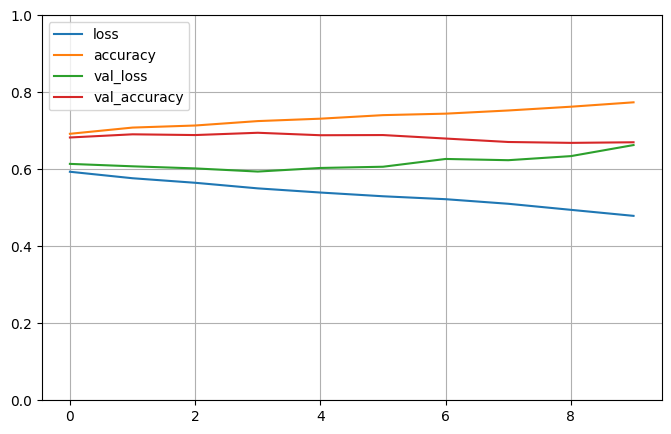

accuracy: 67.01%
Fold 1
Train set ones/size 20208 / 43224
Valid set ones/size 5260 / 11127
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.5906 - accuracy: 0.6927 - val_loss: 0.5931 - val_accuracy: 0.6890
Epoch 2/10
1351/1351 [==============================] - 3s 3ms/step - loss: 0.5699 - accuracy: 0.7113 - val_loss: 0.6068 - val_accuracy: 0.6789
Epoch 3/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.5601 - accuracy: 0.7167 - val_loss: 0.6024 - val_accuracy: 0.6866
Epoch 4/10
1351/1351 [==============================] - 4s 3ms/step - loss: 0.5484 - accuracy: 0.7230 - val_loss: 0.6060 - val_accuracy: 0.6752
Epoch 5/10
1351/1351 [==============================] - 3s 3ms/step - loss: 0.5360 - accuracy: 0.7353 - val_loss: 0.6252 - val_accuracy: 0.6688
Epoch 6/10
1351/1351 [==============================] - 3s 2ms/step - loss: 0.5304 - accuracy: 0.7375 - val_loss: 0.6138 - val_accuracy: 0.6735
Epoch 

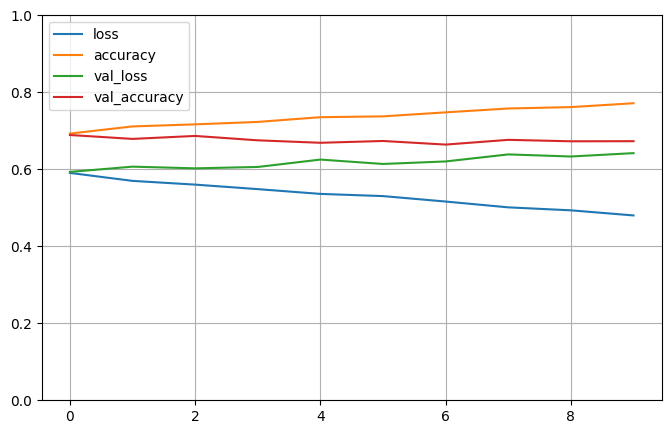

accuracy: 67.30%
Fold 2
Train set ones/size 20485 / 43401
Valid set ones/size 4983 / 10950
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1357/1357 [==============================] - 5s 3ms/step - loss: 0.5948 - accuracy: 0.6898 - val_loss: 0.5978 - val_accuracy: 0.6905
Epoch 2/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5794 - accuracy: 0.7036 - val_loss: 0.5877 - val_accuracy: 0.6959
Epoch 3/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5665 - accuracy: 0.7127 - val_loss: 0.5900 - val_accuracy: 0.6907
Epoch 4/10
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5543 - accuracy: 0.7191 - val_loss: 0.5934 - val_accuracy: 0.6856
Epoch 5/10
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5424 - accuracy: 0.7301 - val_loss: 0.5913 - val_accuracy: 0.6845
Epoch 6/10
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5290 - accuracy: 0.7367 - val_loss: 0.5943 - val_accuracy: 0.6900
Epoch 

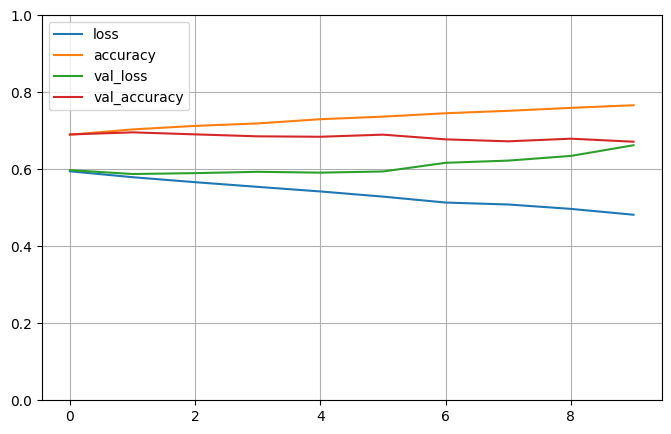

accuracy: 67.16%
Fold 3
Train set ones/size 20676 / 43739
Valid set ones/size 4792 / 10612
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1367/1367 [==============================] - 4s 3ms/step - loss: 0.5956 - accuracy: 0.6898 - val_loss: 0.5999 - val_accuracy: 0.6852
Epoch 2/10
1367/1367 [==============================] - 4s 3ms/step - loss: 0.5748 - accuracy: 0.7061 - val_loss: 0.5958 - val_accuracy: 0.6863
Epoch 3/10
1367/1367 [==============================] - 3s 2ms/step - loss: 0.5692 - accuracy: 0.7099 - val_loss: 0.5900 - val_accuracy: 0.6915
Epoch 4/10
1367/1367 [==============================] - 3s 2ms/step - loss: 0.5584 - accuracy: 0.7175 - val_loss: 0.5934 - val_accuracy: 0.6886
Epoch 5/10
1367/1367 [==============================] - 3s 3ms/step - loss: 0.5542 - accuracy: 0.7212 - val_loss: 0.5928 - val_accuracy: 0.6942
Epoch 6/10
1367/1367 [==============================] - 4s 3ms/step - loss: 0.5455 - accuracy: 0.7282 - val_loss: 0.6060 - val_accuracy: 0.6846
Epoch 

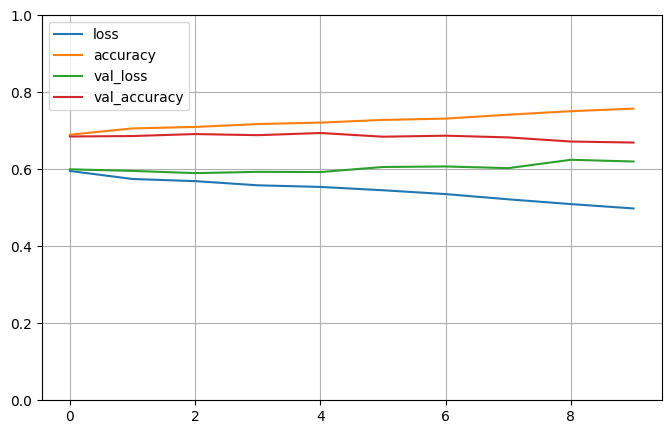

accuracy: 66.94%
Fold 4
Train set ones/size 20010 / 43624
Valid set ones/size 5458 / 10727
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1364/1364 [==============================] - 4s 3ms/step - loss: 0.5912 - accuracy: 0.6955 - val_loss: 0.6074 - val_accuracy: 0.6852
Epoch 2/10
1364/1364 [==============================] - 3s 2ms/step - loss: 0.5709 - accuracy: 0.7111 - val_loss: 0.6015 - val_accuracy: 0.6869
Epoch 3/10
1364/1364 [==============================] - 4s 3ms/step - loss: 0.5647 - accuracy: 0.7152 - val_loss: 0.6111 - val_accuracy: 0.6786
Epoch 4/10
1364/1364 [==============================] - 4s 3ms/step - loss: 0.5534 - accuracy: 0.7226 - val_loss: 0.6038 - val_accuracy: 0.6867
Epoch 5/10
1364/1364 [==============================] - 4s 3ms/step - loss: 0.5430 - accuracy: 0.7301 - val_loss: 0.6180 - val_accuracy: 0.6730
Epoch 6/10
1364/1364 [==============================] - 4s 3ms/step - loss: 0.5310 - accuracy: 0.7364 - val_loss: 0.6137 - val_accuracy: 0.6787
Epoch 

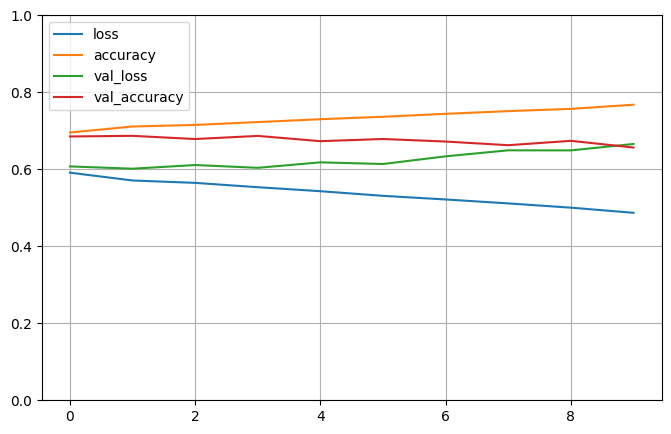

accuracy: 65.65%

Validation core mean 66.81% (+/- 0.59%)
2022-10-16 09:31:49.673094


In [13]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())